In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)


### Import necessary libraries

In [2]:
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import json
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
from tqdm.notebook import tqdm
from tqdm import tqdm  # Importing tqdm

### Error Level Analysis

In [3]:
#converts input image to ela applied image
def convert_to_ela_image(path,quality):

    original_image = Image.open(path).convert('RGB')

    #resaving input image at the desired quality
    resaved_file_name = 'resaved_image.jpg'     #predefined filename for resaved image
    original_image.save(resaved_file_name,'JPEG',quality=quality)
    resaved_image = Image.open(resaved_file_name)

    #pixel difference between original and resaved image
    ela_image = ImageChops.difference(original_image,resaved_image)
    
    #scaling factors are calculated from pixel extremas
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference ==0:
        max_difference = 1
    scale = 350.0 / max_difference
    
    #enhancing elaimage to brighten the pixels
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    ela_image.save("ela_image.png")
    return ela_image

### Dataset Preparation

In [4]:
def prepare_image(image_path):
    image_size = (128, 128)
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0         #normalizing the array values obtained from input image

In [5]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [7]:
#adding authentic images

path = 'CASIA2/Au'       
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(1)     # label for authentic images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images : 100%|██████████| 7492/7492 [07:02<00:00, 17.75it/s]

Total images: 7602
Total labels: 7602


In [8]:
#adding forged images

path = 'CASIA2/Tp'
for filename in tqdm(os.listdir(path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        full_path = os.path.join(path, filename)
        X.append(prepare_image(full_path))        
        Y.append(0)     # label for forged images 
        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

Processing Images : 100%|██████████| 5123/5123 [03:27<00:00, 24.71it/s] 

Total images: 9666
Total labels: 9666


In [9]:
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1, 128, 128, 3) 

### Partitioning dataset for training, validation and testing

In [10]:
# Training : Validation : Testing = 76 : 19 : 5
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

Training images: 7345 , Training labels: 7345
Validation images: 1837 , Validation labels: 1837
Test images: 484 , Test labels: 484


### CNN Model

In [11]:
def build_model():
    model = Sequential()  # Sequential Model
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    return model

In [12]:
model = build_model()
model.summary()

c:\Users\SHIVA SHANKAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,449 (2.17 MB)

 Trainable params: 568,449 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [13]:
epochs = 15
batch_size = 32


In [15]:
#Optimizer
init_lr = 1e-4   #learning rate for the optimizer
optimizer = Adam(learning_rate = init_lr, decay = init_lr/epochs) 
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

c:\Users\SHIVA SHANKAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [16]:
#Early Stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

In [17]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                 validation_data = (X_val, Y_val),
                 callbacks = [early_stopping])

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7680 - loss: 0.4618 - val_accuracy: 0.8601 - val_loss: 0.2887
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8637 - loss: 0.2796 - val_accuracy: 0.8710 - val_loss: 0.2677
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.8751 - loss: 0.2672 - val_accuracy: 0.8726 - val_loss: 0.2618
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8754 - loss: 0.2652 - val_accuracy: 0.8639 - val_loss: 0.2827
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8758 - loss: 0.2675 - val_accuracy: 0.8857 - val_loss: 0.2492
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8957 - loss: 0.2369 - val_accuracy: 0.8884 - val_loss: 0.2431
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9023 - loss: 0.2268 - val_accuracy: 0.9047 - val_loss: 0.2308
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8990 - loss: 0.2326 - val_accu

In [ ]:
#save the model as a h5 file
model.save('.h5') 

# get the dictionary containing each metric and the loss for each epoch
history_dict = hist.history

# save it as a json file
json.dump(history_dict, open('', 'w'))

NameError: name 'hist' is not defined

### Plotting the training and validation curves

NameError: name 'history_dict' is not defined

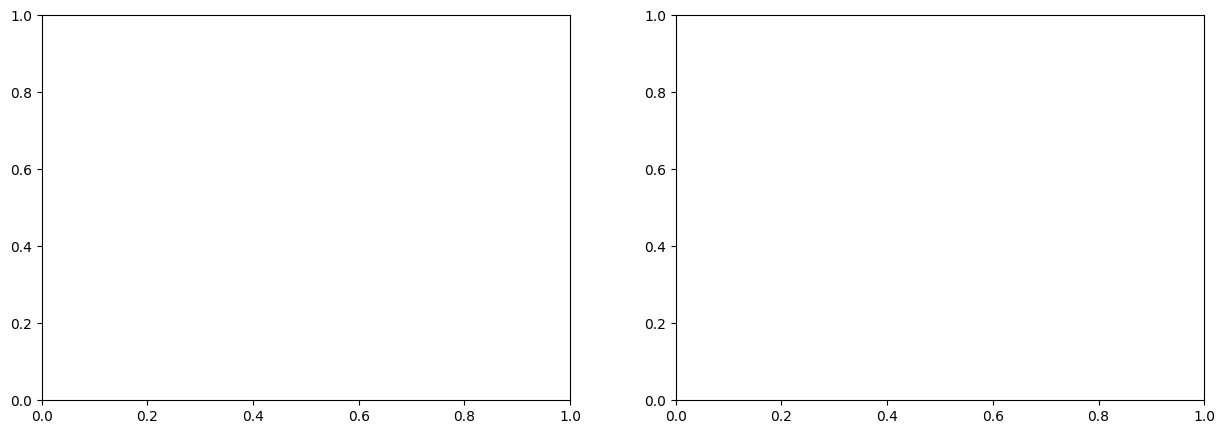

In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

#Figure 1
ax[0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0].plot(history_dict['val_loss'], color='r', label = "Validation loss",axes =ax[0])
ax[0].set_xlabel('Epochs',fontsize=16)
ax[0].set_ylabel('Loss',fontsize=16)
legend = ax[0].legend(loc='best', shadow=True)

#Figure 2
ax[1].plot(history_dict['accuracy'], color='b', label = "Training accuracy")
ax[1].plot(history_dict['val_accuracy'], color='r',label = "Validation accuracy")
ax[1].set_xlabel('Epochs',fontsize=16)
ax[1].set_ylabel('Accuracy',fontsize=16)
legend = ax[1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20)

### Confusion Matrix

In [19]:
def plot_confusion_matrix(cf_matrix):
  
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()] #number of images in each classification block
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)] #percentage value of images in each block w.r.t total images

    axes_labels=['Forged', 'Authentic']
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='',cmap="flare" , xticklabels=axes_labels, yticklabels=axes_labels)

    plot_xlabel = plt.xlabel('Predicted labels', fontsize = 13)
    plot_ylabel = plt.ylabel('True labels', fontsize = 13)
    plot_title = plt.title('Confusion Matrix', fontsize= 10,fontweight='bold')

In [20]:
Y_pred = model.predict(X_val)               # Predict the values from the validation dataset 
Y_pred_classes = np.round(Y_pred)           # roundoff the sigmoid value
Y_true = Y_val                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)     # compute the confusion matrix
plot_confusion_matrix(confusion_mtx)                         # plot the confusion matrix


NameError: name 'X_val' is not defined

### Classification Report

In [21]:
print(classification_report(Y_true, Y_pred_classes))

NameError: name 'Y_true' is not defined

### Testing Accuracy

In [22]:
class_names = ['Forged', 'Authentic']

In [23]:
# Testing accuracy
correct_test = 0 #correctly predicted test images
total_test = 0   #total test images

for index,image in enumerate(tqdm(X_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total_test += 1
    if y_pred_class == Y_test[index]: #if prediction is correct
        correct_test += 1
    
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {correct_test / total_test * 100.0} %')

NameError: name 'X_test' is not defined

# Test an image

In [24]:
test_image_path = ''    # test image path
test_image = prepare_image(test_image_path)
test_image = test_image.reshape(-1, 128, 128, 3)

y_pred = model.predict(test_image)
y_pred_class = round(y_pred[0][0])

fig, ax = plt.subplots(1,2,figsize=(15,5)) 

#display original image
original_image = plt.imread(test_image_path) 
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

#display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path,90)) 
ax[1].set_title('ELA Image')

print(f'Prediction: {class_names[y_pred_class]}')
if y_pred<=0.5:
    print(f'Confidence:  {(1-(y_pred[0][0])) * 100:0.2f}%')
else:
    print(f'Confidence: {(y_pred[0][0]) * 100:0.2f}%')
print('--------------------------------------------------------------------------------------------------------------')

AttributeError: 'str' object has no attribute 'read'

# Test a dataset

In [25]:
test_folder_path = ''        #dataset path
authentic,forged,total = 0,0,0

for filename in tqdm(os.listdir(test_folder_path),desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(path, filename)
        test_image = prepare_image(test_image_path)  
        test_image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.round(y_pred)
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
            authentic +=1

print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

FileNotFoundError: [WinError 3] The system cannot find the path specified: ''